# Example to derive one day of openMRG data, process the CML data and store it together with the reference data as netCDF

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import opensense_data_downloader_and_transformer as oddt
import xarray as xr
import pandas as pd
import pycomlink as pycml
import pyproj
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# function from OpenSense sandbox https://github.com/OpenSenseAction/OPENSENSE_sandbox/blob/main/notebooks/Explore_existing_datasets.ipynb
oddt.download_andersson_2022_OpenMRG(
    local_path="data/andersson_2022_OpenMRG/", print_output=True
)

File already exists at desired location data/andersson_2022_OpenMRG/OpenMRG.zip
Not downloading!


#### get and parse cml data 

In [3]:
# function from sandbox
ds_cml = oddt.transform_andersson_2022_OpenMRG(
    fn="data/andersson_2022_OpenMRG/OpenMRG.zip",
    path_to_extract_to="data/andersson_2022_OpenMRG/",
    time_start_end=(
        None,
        None,
    ),  # default (None, None) -> no timeslicing. ie. ('2015-08-31T00', None),
    restructure_data=True,
)

/bg/home/graf-m/notebooks/cml_method_comparison/waa_comparison/opensense_data_downloader_and_transformer.py:302: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink':df_metadata.index})


#### get city and smhi rain gauge

In [4]:
df_gauges_city = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

df_gauges_city_metadata = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv",
    index_col=0,
)

In [5]:
ds_gauges_city = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["time", "station_id"], df_gauges_city),
    ),
    coords=dict(
        station_id=df_gauges_city_metadata.index.values,
        time=df_gauges_city.index.values,
        lon=(["station_id"], df_gauges_city_metadata.Longitude_DecDeg),
        lat=(["station_id"], df_gauges_city_metadata.Latitude_DecDeg),
        location=(["station_id"], df_gauges_city_metadata.Location),
        type=(["station_id"], df_gauges_city_metadata.Type),
        quantization=(["station_id"], df_gauges_city_metadata["Resolution (mm)"]),
    ),
)


In [6]:
df_gauge_smhi = pd.read_csv(
    "data/andersson_2022_OpenMRG/gauges/smhi/GbgA-71420-2015JJA.csv",
    index_col=0,
    parse_dates=True,
)

# meta data c&p from metadata file
ds_gauges_smhi = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["station_id", "time"], [df_gauge_smhi.Pvol_mm.values]),
    ),
    coords=dict(
        station_id=["SMHI"],
        time=df_gauge_smhi.index.values,
        lon=(["station_id"], [11.9924]),
        lat=(["station_id"], [57.7156]),
        location=(["station_id"], ["Goeteburg A"]),
        type=(["station_id"], ["15 min rainfall sum"]),
        quantization=(["station_id"], [0.1]),
    ),
)

#### Get radar data

In [7]:
ds_radar = xr.open_dataset(
    "data/andersson_2022_OpenMRG/radar/radar.nc"
)

In [8]:
ds_radar["dBZ"] = 0.4 * ds_radar.data - 30
ds_radar["R"] = (10 ** (ds_radar.data / 10) / 200) ** (5 / 8)

In [9]:
x_grid, y_grid = np.meshgrid(ds_radar.x.values, ds_radar.y.values)

transformer = pyproj.Transformer.from_crs(
    "+proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90",
    "EPSG:4326",
    always_xy=True,
)
lon_grid, lat_grid = transformer.transform(xx=x_grid, yy=y_grid)

In [10]:
ds_radar.coords["lon"] = (("y", "x"), lon_grid)
ds_radar.coords["lat"] = (("y", "x"), lat_grid)

#### select one day

In [11]:
ds_cml = ds_cml.sel(time=slice("2015-08-27 00:00:00", "2015-08-27 23:59:59"))
ds_gauges_city = ds_gauges_city.sel(time=slice("2015-08-27 00:00:00", "2015-08-27 23:59:59"))
ds_gauges_smhi = ds_gauges_smhi.sel(time=slice("2015-08-27 00:00:00", "2015-08-27 23:59:59"))
ds_radar = ds_radar.sel(time=slice("2015-08-27 00:00:00", "2015-08-27 23:59:59"))

In [12]:
ds_cml

<xarray.Dataset>
Dimensions:       (sublink_id: 2, cml_id: 364, time: 8640)
Coordinates:
  * sublink_id    (sublink_id) <U9 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * time          (time) datetime64[ns] 2015-08-27 ... 2015-08-27T23:59:50
    site_0_lat    (cml_id) float64 57.7 57.73 57.69 57.71 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 12.0 11.98 11.97 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 57.7 57.72 57.69 57.7 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 11.99 11.97 11.98 11.97 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 2.821e+04 3.853e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v'
    length        (cml_id) float64 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
Data variables:
    tsl           (time, sublink_id, cml_id) float32 1.0 0.0 -5.0 ... 16.0 0.0
    rsl           (time, sublink_id, cml_id) float32 -46.0 -41.0 ... -39.8 -49.8
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [13]:
ds_gauges_city

<xarray.Dataset>
Dimensions:          (time: 1440, station_id: 10)
Coordinates:
  * station_id       (station_id) object 'Jarn' 'Torp' ... 'Lbom' 'Askim'
  * time             (time) datetime64[ns] 2015-08-27 ... 2015-08-27T23:59:00
    lon              (station_id) float64 11.94 12.04 12.07 ... 11.97 11.94
    lat              (station_id) float64 57.65 57.72 57.75 ... 57.71 57.63
    location         (station_id) object 'Järnbrottsmotet' ... 'Askim Ögärdesv'
    type             (station_id) object 'Weighing' ... 'Tipping-bucket'
    quantization     (station_id) float64 0.1 0.1 0.1 0.1 ... 0.1 0.2 0.2 0.2
Data variables:
    rainfall_amount  (time, station_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [14]:
ds_radar

<xarray.Dataset>
Dimensions:  (time: 288, x: 37, y: 48)
Coordinates:
  * time     (time) datetime64[ns] 2015-08-27 ... 2015-08-27T23:55:00
  * x        (x) float64 -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y        (y) float64 -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
    lat      (y, x) float64 58.04 58.04 58.04 58.04 ... 57.23 57.23 57.23 57.23
    lon      (y, x) float64 11.41 11.45 11.48 11.51 ... 12.56 12.59 12.62 12.66
Data variables:
    crs      int32 ...
    data     (time, y, x) float64 -30.0 2.4 6.8 0.8 ... -30.0 -30.0 -30.0 -30.0
    dBZ      (time, y, x) float64 -42.0 -29.04 -27.28 ... -42.0 -42.0 -42.0
    R        (time, y, x) float64 0.0004862 0.05151 ... 0.0004862 0.0004862
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

In [15]:
ds_gauges_smhi

<xarray.Dataset>
Dimensions:          (station_id: 1, time: 96)
Coordinates:
  * station_id       (station_id) <U4 'SMHI'
  * time             (time) datetime64[ns] 2015-08-27 ... 2015-08-27T23:45:00
    lon              (station_id) float64 11.99
    lat              (station_id) float64 57.72
    location         (station_id) <U11 'Goeteburg A'
    type             (station_id) <U19 '15 min rainfall sum'
    quantization     (station_id) float64 0.1
Data variables:
    rainfall_amount  (station_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.1

#### Proccess all data

In [16]:
%%time
ds_cml["tsl"] = ds_cml.tsl.where((ds_cml.tsl > -10) & (ds_cml.tsl < 40))
ds_cml["rsl"] = ds_cml.rsl.where((ds_cml.rsl > -95) & (ds_cml.rsl < 0))

ds_cml["tl"] = ds_cml.tsl - ds_cml.rsl
ds_cml["tl"] = ds_cml.tl.interpolate_na(dim="time", max_gap="5min", method="linear")

ds_cml["wet"] = ds_cml.tl.rolling(time=60, center=True).std(skipna=False) > 0.6

ds_cml["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml.tl,
    wet=ds_cml.wet,
    n_average_last_dry=30,
)

ds_cml["A_obs"] = ds_cml.tl - ds_cml.baseline
ds_cml["A_obs"] = ds_cml.A_obs.where(ds_cml.A_obs >= 0, 0)

ds_cml["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cml.A_obs,
    f_Hz=ds_cml.frequency * 1e6,
    pol=ds_cml.polarization,
    L_km=ds_cml.length / 1000,
    A_max=5
)

ds_cml["A"] = ds_cml.A_obs - ds_cml.waa 
ds_cml["A"] = ds_cml.A.where(ds_cml.A >= 0, 0)


ds_cml["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cml.A,
    L_km=ds_cml.length / 1000,
    f_GHz=ds_cml.frequency / 1e3,
    pol=ds_cml.polarization,
)

CPU times: user 1.85 s, sys: 119 ms, total: 1.97 s
Wall time: 2.05 s


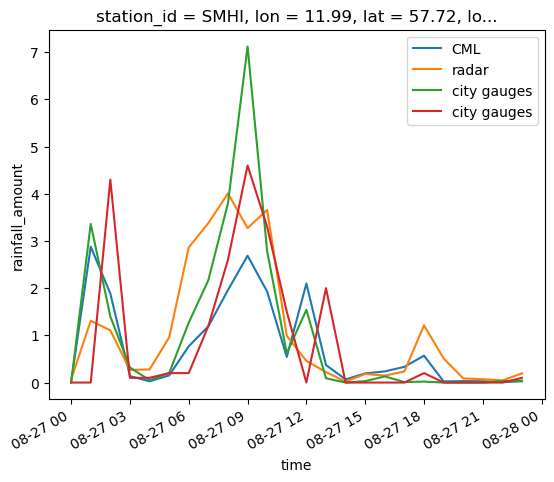

In [17]:
(ds_cml.R.isel(sublink_id=0).mean(dim='cml_id')/360).resample(time='60min').sum().plot(label='CML')
(ds_radar.R.mean(dim=['x','y'])/12).resample(time='60min').sum().plot(label='radar')
(ds_gauges_city.rainfall_amount.mean(dim='station_id')).resample(time='60min').sum().plot(label='city gauges')
ds_gauges_smhi.rainfall_amount.resample(time='60min').sum().plot(label='city gauges')
plt.legend()

In [18]:
ds_cml.to_netcdf("openMRG_cml_20150827.nc")
ds_radar.to_netcdf("openMRG_radar_20150827.nc")
ds_gauges_city.to_netcdf("openMRG_city_gauges_20150827.nc")
ds_gauges_smhi.to_netcdf("openMRG_smhi_gauge_20150827.nc")